In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats


W_ANCHOR = 'W-SUN'     # weekly anchor 
TEST_WINDOW_WEEKS = 5  # walk-forward test length
MIN_TRAIN_WEEKS = 52   # warm-up (1 year) before first test
N_SIM = 50_000         # Monte Carlo reps per split (distributed across horizon weeks)
RANDOM_STATE = 42


# Candidate residual distributions
CANDIDATES = {
    "norm":     stats.norm,
    "lognorm":  stats.lognorm,   # for skewed positive residuals
    "gamma":    stats.gamma,
    "t":        stats.t,
}

def fit_best_distribution(y, bins=50):
    """
    Fit candidate distributions to 1D data y (residuals).
    Uses RSS between empirical histogram and model PDF over bin centers.
    Also computes KS statistic for the best fit.
    Returns: dict(name, dist, params, rss, ks_stat, ks_pvalue)
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    if y.size < 10:
        return None

    hist, bin_edges = np.histogram(y, bins=bins, density=True)
    centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    best = {"name": None, "dist": None, "params": None,
            "rss": np.inf, "ks_stat": None, "ks_pvalue": None}

    for name, dist in CANDIDATES.items():
        try:
            params = dist.fit(y)                       # (shape(s), loc, scale)
            model_pdf = dist.pdf(centers, *params)
            rss = np.sum((hist - model_pdf)**2)
            if rss < best["rss"]:
                best.update({"name": name, "dist": dist, "params": params, "rss": rss})
        except Exception:
            continue

    if best["dist"] is not None:
        ks_stat, ks_p = stats.kstest(y, best["dist"].cdf, args=best["params"])
        best["ks_stat"], best["ks_pvalue"] = ks_stat, ks_p

    return best


### Preparing: split data (robust weekly anchor)

df = pd.read_excel('/Users/jinnanut/Library/Mobile Documents/com~apple~CloudDocs/NUT/Exeter University/Master/Term 3/BEMM466 Business Project/Dissertation/Data/WeeklyData.xlsx')
df['date'] = pd.to_datetime(df['date'])

categories = df['category'].unique()
category_data = {}

test_window = pd.Timedelta(weeks=TEST_WINDOW_WEEKS)

for cat in categories:
    print(f"\nProcessing category: {cat}")
    df_cat = df[df["category"] == cat].copy()
    df_cat = df_cat.set_index('date').sort_index()

    # Resample to weekly sums on the chosen anchor
    df_cat = df_cat[["quantity"]].resample(W_ANCHOR, label="right", closed="right").sum()

    # Force a complete weekly grid on that anchor
    if not df_cat.empty:
        full_idx = pd.date_range(df_cat.index.min(), df_cat.index.max(), freq=W_ANCHOR)
        df_cat = df_cat.reindex(full_idx).fillna(0.0)
        df_cat.index.name = "date"

        # Basic spacing sanity
        assert df_cat.index.is_monotonic_increasing, "Index not increasing"
        deltas = df_cat.index.to_series().diff().dropna()
        assert (deltas == pd.Timedelta(weeks=1)).all(), "Index is not strictly weekly spaced"

    category_data[cat] = {"full": df_cat}

    # Walk-forward train/test windows
    start_train = pd.Timestamp("2019-01-01")
    end_of_data = df_cat.index.max() if not df_cat.empty else None

    split_idx = 1
    test_start = start_train + pd.Timedelta(weeks=MIN_TRAIN_WEEKS)  # start after warm-up
    test_end = test_start + test_window - pd.Timedelta(days=1)

    while end_of_data is not None and test_end <= end_of_data:
        train_start = start_train
        train_end = test_start - pd.Timedelta(days=1)

        train_data = df_cat.loc[train_start:train_end]
        test_data = df_cat.loc[test_start:test_end]

        if train_data.empty or test_data.empty:
            print(f"  Skipping split {split_idx}: empty train or test")
        else:
            category_data[cat][f"train_{split_idx}"] = train_data
            category_data[cat][f"test_{split_idx}"] = test_data
            print(f"  Split {split_idx}: Train = {train_start.date()} to {train_end.date()}, "
                  f"Test = {test_start.date()} to {test_end.date()}")

        test_start += test_window
        test_end = test_start + test_window - pd.Timedelta(days=1)
        split_idx += 1

# Preview
if len(categories) > 0:
    sample_cat = categories[0]
    print(f"\nPreview for category '{sample_cat}':")
    print(category_data[sample_cat]["full"].head())



Processing category: Furniture
  Split 1: Train = 2019-01-01 to 2019-12-30, Test = 2019-12-31 to 2020-02-03
  Split 2: Train = 2019-01-01 to 2020-02-03, Test = 2020-02-04 to 2020-03-09
  Split 3: Train = 2019-01-01 to 2020-03-09, Test = 2020-03-10 to 2020-04-13
  Split 4: Train = 2019-01-01 to 2020-04-13, Test = 2020-04-14 to 2020-05-18
  Split 5: Train = 2019-01-01 to 2020-05-18, Test = 2020-05-19 to 2020-06-22
  Split 6: Train = 2019-01-01 to 2020-06-22, Test = 2020-06-23 to 2020-07-27
  Split 7: Train = 2019-01-01 to 2020-07-27, Test = 2020-07-28 to 2020-08-31
  Split 8: Train = 2019-01-01 to 2020-08-31, Test = 2020-09-01 to 2020-10-05
  Split 9: Train = 2019-01-01 to 2020-10-05, Test = 2020-10-06 to 2020-11-09
  Split 10: Train = 2019-01-01 to 2020-11-09, Test = 2020-11-10 to 2020-12-14
  Split 11: Train = 2019-01-01 to 2020-12-14, Test = 2020-12-15 to 2021-01-18
  Split 12: Train = 2019-01-01 to 2021-01-18, Test = 2021-01-19 to 2021-02-22
  Split 13: Train = 2019-01-01 to 2021-02

### Step 1: Seasonality index & Feature Engineering (for ML)

In [2]:
# Compute weekly seasonality and build ML-ready features (lags, rolling stats, calendar)

seasonality_results = {}
feature_mats = {}  # holds per-cat per-split (X_train, y_train, X_test, y_test, index_test)

def make_features(weekly_df, lags=(1,2,3,4,8,12,52), roll_windows=(4,8,12)):
    """
    Build a supervised feature matrix from a weekly series DataFrame with column 'quantity'
    Returns a DataFrame with engineered features aligned to the target.
    """
    df_feat = weekly_df.copy()
    df_feat["week"] = df_feat.index.isocalendar().week.astype(int)
    df_feat["year"] = df_feat.index.isocalendar().year.astype(int)

    # Rolling seasonality index by ISO week (simple ratio: week mean / overall mean)
    overall_avg = df_feat["quantity"].mean() if df_feat["quantity"].mean() != 0 else 1.0
    weekly_avg = df_feat.groupby("week")["quantity"].transform("mean")
    df_feat["seasonal_index"] = (weekly_avg / overall_avg).replace([np.inf, -np.inf], np.nan).fillna(1.0)

    # Lags
    for L in lags:
        df_feat[f"lag_{L}"] = df_feat["quantity"].shift(L)

    # Rolling stats on levels
    for w in roll_windows:
        df_feat[f"roll_mean_{w}"] = df_feat["quantity"].rolling(w, min_periods=1).mean()
        df_feat[f"roll_std_{w}"]  = df_feat["quantity"].rolling(w, min_periods=1).std().fillna(0.0)

    # Simple calendar dummies: month-of-year via anchor date
    df_feat["month"] = df_feat.index.month

    # Target
    df_feat["y"] = df_feat["quantity"]

    # Drop rows with insufficient history (due to lags)
    max_lag = max(lags) if lags else 0
    df_feat = df_feat.iloc[max_lag:].copy()

    # Final feature set
    feature_cols = (
        [f"lag_{L}" for L in lags] +
        [f"roll_mean_{w}" for w in roll_windows] +
        [f"roll_std_{w}" for w in roll_windows] +
        ["seasonal_index", "week", "month", "year"]
    )

    X = df_feat[feature_cols].astype(float)
    y = df_feat["y"].astype(float)
    return X, y, feature_cols

for cat in categories:
    print(f"\nBuilding seasonality + features for: {cat}")
    seasonality_results[cat] = {}
    feature_mats[cat] = {}
    for key, df_part in category_data[cat].items():
        if not key.startswith("train_"):
            continue

        # Seasonality index
        train_df = category_data[cat][key].copy()
        if train_df.empty: 
            print(f"  Skipping {cat} - {key}: empty train data.")
            continue

        train_df["week"] = train_df.index.isocalendar().week
        overall_avg = train_df["quantity"].mean() or 1.0
        weekly_avg = train_df.groupby("week")["quantity"].mean()
        seasonal_index = (weekly_avg / overall_avg).replace([np.inf, -np.inf], np.nan).fillna(1.0)

        seasonality_results[cat][key] = {
            "seasonal_index": seasonal_index
        }

        # Build features on the FULL series, then can slice exact train/test windows on aligned rows
        full_series = category_data[cat]["full"]

        # Build features once on full, then slice by date windows to align X_train/X_test
        X_full, y_full, feat_cols = make_features(full_series)

        # Align with original dates
        aligned_idx = full_series.iloc[max(1, X_full.shape[0]-len(X_full)):].index
        # After make_features, X_full index == full_series.index[max_lag:]
        max_lag = 52  # from lags above
        aligned_idx = full_series.index[max_lag:]

        X_full.index = aligned_idx
        y_full.index = aligned_idx

        # Slice by the explicit train/test windows for this split
        # (recompute train_end/test_start/test_end from strings)
        split_num = key.split("_")[1]
        test_key = f"test_{split_num}"
        if test_key not in category_data[cat]:
            continue

        train_start = category_data[cat][key].index.min()
        train_end   = category_data[cat][key].index.max()
        test_start  = category_data[cat][test_key].index.min()
        test_end    = category_data[cat][test_key].index.max()

        X_train = X_full.loc[train_start:train_end]
        y_train = y_full.loc[train_start:train_end]
        X_test  = X_full.loc[test_start:test_end]
        y_test  = y_full.loc[test_start:test_end]

        # Guard against empties
        if X_train.empty or X_test.empty:
            print(f"  Skipping {cat} - {key}: empty X after lag alignment.")
            continue

        feature_mats[cat][key] = {
            "X_train": X_train, "y_train": y_train,
            "X_test":  X_test,  "y_test":  y_test,
            "index_test": X_test.index,
            "feature_cols": feat_cols
        }
        print(f"  {key}: features ready — train={len(X_train)}, test={len(X_test)}")



Building seasonality + features for: Furniture
  Skipping Furniture - train_1: empty X after lag alignment.
  train_2: features ready — train=5, test=5
  train_3: features ready — train=10, test=5
  train_4: features ready — train=15, test=5
  train_5: features ready — train=20, test=5
  train_6: features ready — train=25, test=5
  train_7: features ready — train=30, test=5
  train_8: features ready — train=35, test=5
  train_9: features ready — train=40, test=5
  train_10: features ready — train=45, test=5
  train_11: features ready — train=50, test=5
  train_12: features ready — train=55, test=5
  train_13: features ready — train=60, test=5
  train_14: features ready — train=65, test=5
  train_15: features ready — train=70, test=5
  train_16: features ready — train=75, test=5
  train_17: features ready — train=80, test=5
  train_18: features ready — train=85, test=5
  train_19: features ready — train=90, test=5
  train_20: features ready — train=95, test=5
  train_21: features ready

### Step 2: ML Forecast Model (split-wise)

In [3]:
ml_models = {}        # cat -> split -> fitted pipeline
ml_forecasts = {}     # cat -> split -> (yhat_train, yhat_test)

for cat in feature_mats:
    print(f"\nTraining ML models for: {cat}")
    ml_models[cat] = {}
    ml_forecasts[cat] = {}
    for train_key, payload in feature_mats[cat].items():
        X_train = payload["X_train"]; y_train = payload["y_train"]
        X_test  = payload["X_test"];  y_test  = payload["y_test"]

        # Simple, strong baseline pipeline (scaler + GBDT)
        model = Pipeline([
            ("scaler", StandardScaler(with_mean=False)),  # sparse-safe
            ("gbr", GradientBoostingRegressor(
                n_estimators=500,
                max_depth=3,
                learning_rate=0.05,
                random_state=RANDOM_STATE
            ))
        ])
        model.fit(X_train, y_train)

        yhat_train = pd.Series(model.predict(X_train), index=X_train.index)
        yhat_test  = pd.Series(model.predict(X_test),  index=X_test.index)

        ml_models[cat][train_key] = model
        ml_forecasts[cat][train_key] = {
            "yhat_train": yhat_train,
            "yhat_test":  yhat_test,
            "y_test":     y_test
        }
        rmse_tr = mean_squared_error(y_train, yhat_train, squared=False)
        rmse_te = mean_squared_error(y_test,  yhat_test,  squared=False)
        print(f"  {train_key}: RMSE train={rmse_tr:.2f} | test={rmse_te:.2f}")



Training ML models for: Furniture
  train_2: RMSE train=0.00 | test=11.93
  train_3: RMSE train=0.00 | test=3.93
  train_4: RMSE train=0.00 | test=9.97
  train_5: RMSE train=0.00 | test=15.11
  train_6: RMSE train=0.00 | test=11.92
  train_7: RMSE train=0.00 | test=14.15
  train_8: RMSE train=0.00 | test=2.31
  train_9: RMSE train=0.00 | test=14.67
  train_10: RMSE train=0.00 | test=8.15
  train_11: RMSE train=0.00 | test=8.16
  train_12: RMSE train=0.00 | test=12.87
  train_13: RMSE train=0.01 | test=8.52
  train_14: RMSE train=0.01 | test=24.01
  train_15: RMSE train=0.02 | test=3.38
  train_16: RMSE train=0.02 | test=14.15
  train_17: RMSE train=0.03 | test=6.66
  train_18: RMSE train=0.05 | test=1.85
  train_19: RMSE train=0.06 | test=9.46
  train_20: RMSE train=0.06 | test=3.51
  train_21: RMSE train=0.09 | test=10.07
  train_22: RMSE train=0.10 | test=7.22
  train_23: RMSE train=0.10 | test=11.47
  train_24: RMSE train=0.10 | test=11.24
  train_25: RMSE train=0.12 | test=7.55
  

### Step 3: Residuals + Conformal Calibration

In [4]:
TARGET_COVERAGE = 0.80   # target two-sided coverage
CAL_WEEKS       = 26     # use last 26 train weeks as calibration set
BOOTSTRAP_MIN_N = 200    # fallback to parametric if residual history too short

residual_store = {}   # cat -> split -> dict(resid_all, resid_cal, q_abs, infl_factor)
for cat in ml_forecasts:
    print(f"\nCalibrating residuals for coverage (conformal): {cat}")
    residual_store[cat] = {}

    for train_key, preds in ml_forecasts[cat].items():
        y_train     = feature_mats[cat][train_key]["y_train"]
        yhat_train  = preds["yhat_train"].reindex(y_train.index)
        resid_all   = (y_train - yhat_train).dropna().values

        if resid_all.size == 0:
            print(f"  {train_key}: no residuals; skipping.")
            continue

        # Define calibration window from the tail of TRAIN
        cal_n = min(CAL_WEEKS, len(yhat_train))
        resid_cal = (y_train.iloc[-cal_n:] - yhat_train.iloc[-cal_n:]).dropna().values
        if resid_cal.size < 10:  # guard
            resid_cal = resid_all[-min(50, resid_all.size):]  # fallback to last 50

        # Conformal absolute-residual quantile for two-sided intervals
        # For split-conformal, a common finite-sample adjustment is:
        # q = quantile at ceil((n_cal+1)*TARGET_COVERAGE)/n_cal
        q_abs = np.quantile(np.abs(resid_cal), TARGET_COVERAGE)

        # If we later still want parametric draws, pre-fit a fallback dist
        best = fit_best_distribution(resid_all, bins=50)
        if best is None or best["name"] is None:
            mu, std = 0.0, np.std(resid_all) if np.std(resid_all) > 0 else 1.0
            best = {"name": "norm(fallback)", "dist": stats.norm, "params": (mu, std),
                    "rss": np.nan, "ks_stat": np.nan, "ks_pvalue": np.nan}

        # Compute how "wide" the raw residuals are vs calibration quantile
        base_q = np.quantile(np.abs(resid_all), TARGET_COVERAGE)
        infl_factor = (q_abs / base_q) if base_q > 0 else 1.0

        residual_store[cat][train_key] = {
            "resid_all": resid_all,
            "resid_cal": resid_cal,
            "q_abs": q_abs,
            "infl_factor": infl_factor,
            "parametric": best,   # optional fallback
        }

        print(f"  {train_key}: q_abs={q_abs:.3f}, infl_factor={infl_factor:.3f}, "
              f"resid_all={len(resid_all)}, resid_cal={len(resid_cal)}, best={best['name']}")



Calibrating residuals for coverage (conformal): Furniture
  train_2: q_abs=0.000, infl_factor=1.000, resid_all=5, resid_cal=5, best=norm(fallback)
  train_3: q_abs=0.000, infl_factor=1.000, resid_all=10, resid_cal=10, best=t
  train_4: q_abs=0.000, infl_factor=1.000, resid_all=15, resid_cal=15, best=norm
  train_5: q_abs=0.000, infl_factor=1.000, resid_all=20, resid_cal=20, best=t
  train_6: q_abs=0.000, infl_factor=1.000, resid_all=25, resid_cal=25, best=lognorm
  train_7: q_abs=0.000, infl_factor=1.236, resid_all=30, resid_cal=26, best=gamma


/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


  train_8: q_abs=0.001, infl_factor=1.018, resid_all=35, resid_cal=26, best=lognorm
  train_9: q_abs=0.001, infl_factor=1.040, resid_all=40, resid_cal=26, best=norm
  train_10: q_abs=0.002, infl_factor=1.046, resid_all=45, resid_cal=26, best=gamma
  train_11: q_abs=0.003, infl_factor=1.152, resid_all=50, resid_cal=26, best=gamma
  train_12: q_abs=0.005, infl_factor=0.949, resid_all=55, resid_cal=26, best=lognorm
  train_13: q_abs=0.005, infl_factor=0.913, resid_all=60, resid_cal=26, best=t
  train_14: q_abs=0.014, infl_factor=0.880, resid_all=65, resid_cal=26, best=lognorm
  train_15: q_abs=0.016, infl_factor=0.607, resid_all=70, resid_cal=26, best=t
  train_16: q_abs=0.019, infl_factor=0.677, resid_all=75, resid_cal=26, best=t
  train_17: q_abs=0.030, infl_factor=0.874, resid_all=80, resid_cal=26, best=lognorm
  train_18: q_abs=0.044, infl_factor=0.779, resid_all=85, resid_cal=26, best=t
  train_19: q_abs=0.067, infl_factor=0.922, resid_all=90, resid_cal=26, best=t
  train_20: q_abs=0

### Step 4: Monte Carlo with Bootstrap + Conformal Inflation

In [5]:
# Target coverage corresponds two-sided interval (e.g., 0.80 ≈ P10–P90)
TARGET_COVERAGE = 0.80
CAL_WEEKS       = 26      # last N train weeks used for conformal calibration
BOOTSTRAP_MIN_N = 200     # if not enough residuals, fall back to parametric
STRATIFY_BY_WEEK = True   # set False to use global bootstrap only

rng = np.random.default_rng(RANDOM_STATE)

def _stratified_bootstrap(resid_series, test_index, K, fallback_vals):
    """
    Residual stratification by ISO week-of-year:
    For each test week, sample residuals from same bucket; if bucket too small, use fallback.
    resid_series: pd.Series of residuals indexed by date (train dates)
    test_index:   DatetimeIndex of test horizon
    K:            number of replications per week
    fallback_vals: np.ndarray of all residual values (for global fallback)
    Returns: np.ndarray of shape (T, K)
    """
    if not STRATIFY_BY_WEEK:
        idx_boot = rng.integers(0, fallback_vals.size, size=len(test_index) * K)
        return fallback_vals[idx_boot].reshape(len(test_index), K)

    # Build buckets
    resid_buckets = {}
    for dt, r in resid_series.items():
        wk = dt.isocalendar().week
        resid_buckets.setdefault(wk, []).append(r)
        
    # Convert lists to arrays
    for wk in list(resid_buckets.keys()):
        resid_buckets[wk] = np.asarray(resid_buckets[wk], dtype=float)

    # Sample per test week
    T = len(test_index)
    sim = np.empty((T, K), dtype=float)
    for i, dt in enumerate(test_index):
        wk = dt.isocalendar().week
        bucket = resid_buckets.get(wk, None)
        if bucket is None or bucket.size < 20:  # need some mass; else global fallback
            pool = fallback_vals
        else:
            pool = bucket
        idx_boot = rng.integers(0, pool.size, size=K)
        sim[i, :] = pool[idx_boot]
    return sim

simulated_forecasts = {}  # cat -> split -> dict with matrix and index

for cat in ml_forecasts:
    print(f"\nSimulating with calibrated uncertainty: {cat}")
    simulated_forecasts[cat] = {}

    for train_key, preds in ml_forecasts[cat].items():
        yhat_test = preds["yhat_test"]
        T = len(yhat_test)
        if T == 0:
            continue

        K = max(1, N_SIM // T)

        # Build train residuals (with dates)
        y_train    = feature_mats[cat][train_key]["y_train"]
        yhat_train = preds["yhat_train"].reindex(y_train.index)
        resid_ser  = (y_train - yhat_train).dropna()        # pd.Series aligned to dates
        resid_vals = resid_ser.values

        if resid_vals.size == 0:
            # Degenerate fallback: small noise to avoid crash
            sim_resid = rng.normal(0, 1.0, size=T * K).reshape(T, K)
            q_abs = 1.0
            infl_factor = 1.0
        else:
            # Conformal calibration on the most recent CAL_WEEKS of train
            cal_n  = min(CAL_WEEKS, resid_ser.shape[0])
            resid_cal = resid_ser.iloc[-cal_n:].values
            if resid_cal.size < 10:
                # beef up with last 50 global residuals if needed
                resid_cal = resid_vals[-min(50, resid_vals.size):]
            q_abs = np.quantile(np.abs(resid_cal), TARGET_COVERAGE)

            # Bootstrap residuals (stratified by week-of-year)
            if resid_vals.size >= BOOTSTRAP_MIN_N:
                sim_resid = _stratified_bootstrap(resid_ser, yhat_test.index, K, resid_vals)
            else:
                # parametric fallback if history is tiny
                mu, std = np.mean(resid_vals), np.std(resid_vals)
                std = std if std > 0 else 1.0
                sim_resid = rng.normal(mu, std, size=T * K).reshape(T, K)

            # Global inflation so that absolute residual quantile matches conformal q_abs
            base_q = np.quantile(np.abs(resid_vals), TARGET_COVERAGE)
            infl_factor = (q_abs / base_q) if base_q > 0 else 1.0
            sim_resid = sim_resid * infl_factor

        # Combine ML mean + simulated residuals
        mu = yhat_test.to_numpy().reshape(-1, 1)
        sim_values = mu + sim_resid
        sim_values = np.clip(sim_values, 0.0, None)  # demand >= 0

        # Conformal (non-simulated) band for quick comparison
        conformal_lo = (mu.flatten() - q_abs)
        conformal_hi = (mu.flatten() + q_abs)

        simulated_forecasts[cat][train_key] = {
            "simulated": sim_values,      # (T, K)
            "index": yhat_test.index,
            "conformal_lo": conformal_lo, # arrays aligned to index
            "conformal_hi": conformal_hi,
            "infl_factor": infl_factor,
            "q_abs": q_abs,
        }
        print(f"  {train_key}: simulated {sim_values.shape} (T x K), "
              f"q_abs={q_abs:.3f}, infl={infl_factor:.3f}")



Simulating with calibrated uncertainty: Furniture
  train_2: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.000
  train_3: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.000
  train_4: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.000
  train_5: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.000
  train_6: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.000
  train_7: simulated (5, 10000) (T x K), q_abs=0.000, infl=1.236
  train_8: simulated (5, 10000) (T x K), q_abs=0.001, infl=1.018
  train_9: simulated (5, 10000) (T x K), q_abs=0.001, infl=1.040
  train_10: simulated (5, 10000) (T x K), q_abs=0.002, infl=1.046
  train_11: simulated (5, 10000) (T x K), q_abs=0.003, infl=1.152
  train_12: simulated (5, 10000) (T x K), q_abs=0.005, infl=0.949
  train_13: simulated (5, 10000) (T x K), q_abs=0.005, infl=0.913
  train_14: simulated (5, 10000) (T x K), q_abs=0.014, infl=0.880
  train_15: simulated (5, 10000) (T x K), q_abs=0.016, infl=0.607
  train_16: simulated (5, 10000) 

### Step 5: Aggregate & Summarize (TEST) + Coverage diagnostics

In [6]:
weekly_summary = {}   # cat -> split -> DataFrame
coverage_summary = [] # rows for a small report

for cat in simulated_forecasts:
    print(f"\nSummarizing calibrated simulations for: {cat}")
    weekly_summary[cat] = {}
    raw_weekly = category_data[cat]["full"]  # actuals

    for train_key, payload in simulated_forecasts[cat].items():
        sim_vals = payload["simulated"]  # (T, K)
        idx      = payload["index"]
        sim_df   = pd.DataFrame(sim_vals, index=idx)

        # MC bands
        mean_forecast = sim_df.mean(axis=1)
        p10 = sim_df.quantile(0.10, axis=1)
        p90 = sim_df.quantile(0.90, axis=1)

        # Conformal bands (deterministic)
        conf_lo = pd.Series(payload["conformal_lo"], index=idx)
        conf_hi = pd.Series(payload["conformal_hi"], index=idx)

        # Actuals aligned
        actual = raw_weekly.reindex(idx)["quantity"]

        out = pd.DataFrame({
            "mean_forecast": mean_forecast,
            "p10": p10,
            "p90": p90,
            "conf_lo": conf_lo,
            "conf_hi": conf_hi,
            "actual": actual
        })
        weekly_summary[cat][train_key] = out

        # Coverage diagnostics (per split)
        mask_valid = out["actual"].notna()
        cov_mc   = ((out.loc[mask_valid, "actual"] >= out.loc[mask_valid, "p10"]) &
                    (out.loc[mask_valid, "actual"] <= out.loc[mask_valid, "p90"])).mean()
        cov_conf = ((out.loc[mask_valid, "actual"] >= out.loc[mask_valid, "conf_lo"]) &
                    (out.loc[mask_valid, "actual"] <= out.loc[mask_valid, "conf_hi"])).mean()

        avg_w_mc   = (out["p90"] - out["p10"]).mean()
        avg_w_conf = (out["conf_hi"] - out["conf_lo"]).mean()

        coverage_summary.append({
            "Category": cat,
            "Split": train_key,
            "Coverage_MC": float(cov_mc),
            "Avg_Width_MC": float(avg_w_mc),
            "Coverage_Conformal": float(cov_conf),
            "Avg_Width_Conformal": float(avg_w_conf),
            "Inflation_Factor": float(payload["infl_factor"]),
            "q_abs": float(payload["q_abs"]),
        })

        print(f"  {train_key}: MC cov={cov_mc:.3f}, width={avg_w_mc:.3f} | "
              f"Conf cov={cov_conf:.3f}, width={avg_w_conf:.3f}")

# Overall report
coverage_report = pd.DataFrame(coverage_summary)
if not coverage_report.empty:
    overall = coverage_report.agg({
        "Coverage_MC":"mean",
        "Avg_Width_MC":"mean",
        "Coverage_Conformal":"mean",
        "Avg_Width_Conformal":"mean",
        "Inflation_Factor":"mean",
        "q_abs":"mean"
    }).to_dict()
    print("\n=== Coverage Summary (averaged across splits/categories) ===")
    print({k: round(v, 3) for k, v in overall.items()})


Summarizing calibrated simulations for: Furniture
  train_2: MC cov=0.000, width=0.000 | Conf cov=0.000, width=0.000
  train_3: MC cov=0.000, width=0.000 | Conf cov=0.000, width=0.000
  train_4: MC cov=0.000, width=0.000 | Conf cov=0.000, width=0.000
  train_5: MC cov=0.000, width=0.000 | Conf cov=0.000, width=0.000
  train_6: MC cov=0.200, width=0.000 | Conf cov=0.000, width=0.000
  train_7: MC cov=0.000, width=0.000 | Conf cov=0.000, width=0.000
  train_8: MC cov=0.200, width=0.001 | Conf cov=0.000, width=0.001
  train_9: MC cov=0.000, width=0.001 | Conf cov=0.000, width=0.001
  train_10: MC cov=0.000, width=0.005 | Conf cov=0.000, width=0.005
  train_11: MC cov=0.200, width=0.004 | Conf cov=0.000, width=0.005
  train_12: MC cov=0.000, width=0.010 | Conf cov=0.000, width=0.009
  train_13: MC cov=0.000, width=0.012 | Conf cov=0.000, width=0.010
  train_14: MC cov=0.000, width=0.032 | Conf cov=0.000, width=0.029
  train_15: MC cov=0.000, width=0.034 | Conf cov=0.000, width=0.031
  tra

### Step 6: Evaluation & Plots


Building overall TEST evaluation for: Furniture


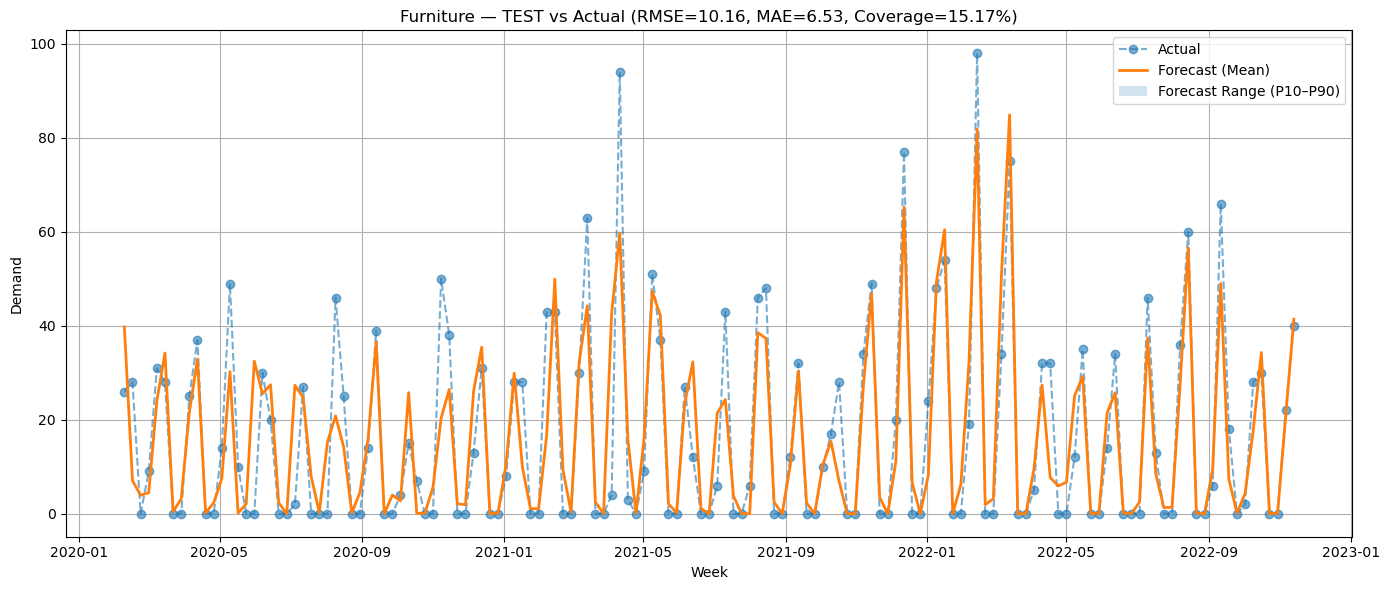


Building overall TEST evaluation for: Office Supplies


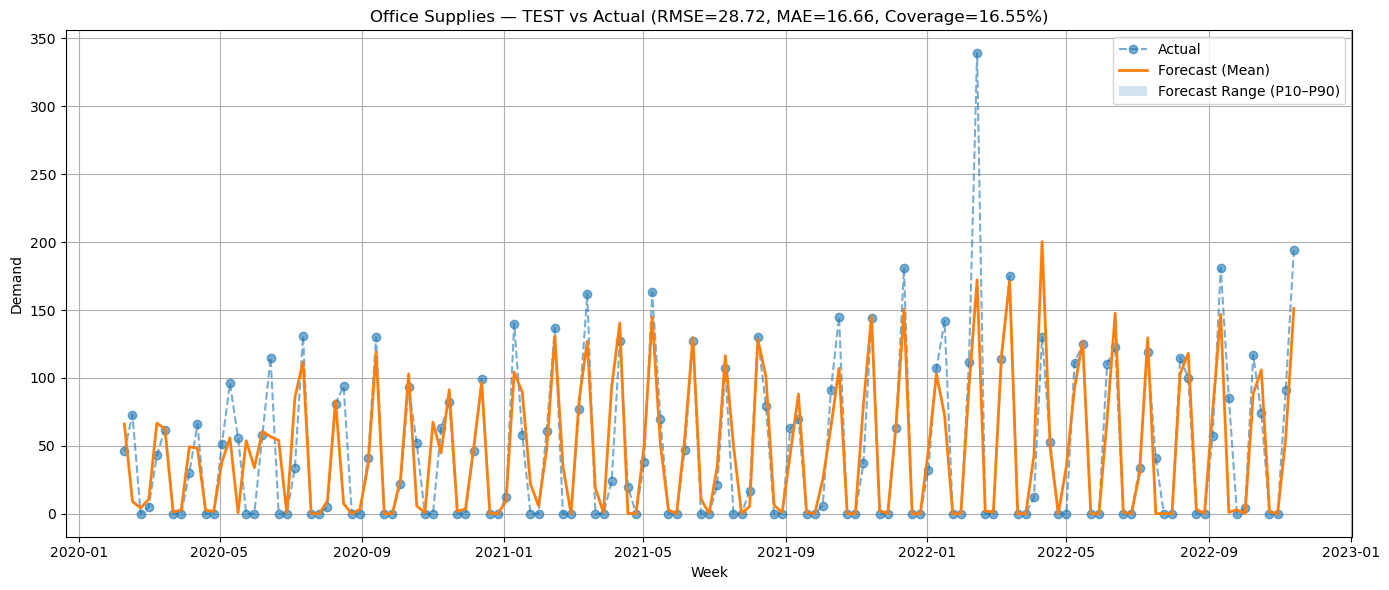


Building overall TEST evaluation for: Technology


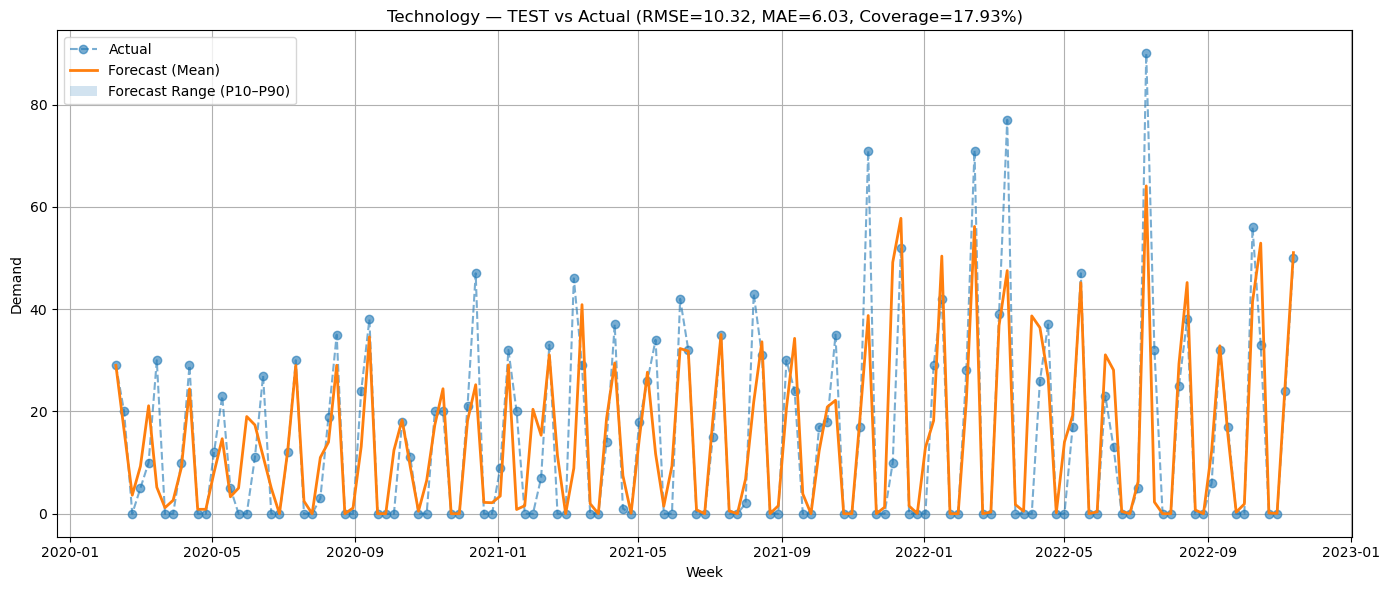

In [7]:
test_forecasts = {}

for cat in categories:
    print(f"\nBuilding overall TEST evaluation for: {cat}")
    # Concatenate all non-overlapping test windows in date order
    rows = []
    for key in sorted(weekly_summary.get(cat, {}).keys(),
                      key=lambda k: int(k.split("_")[1]) if "_" in k else 0):
        rows.append(weekly_summary[cat][key])

    if not rows:
        print(f"  No TEST windows available for {cat}.")
        continue

    big_test = pd.concat(rows).sort_index()
    big_test = big_test.dropna(subset=["mean_forecast", "actual"])

    # Metrics
    rmse = mean_squared_error(big_test["actual"], big_test["mean_forecast"], squared=False)
    mae  = mean_absolute_error(big_test["actual"], big_test["mean_forecast"])
    coverage = ((big_test["actual"] >= big_test["p10"]) & (big_test["actual"] <= big_test["p90"])).mean()

    test_forecasts[cat] = big_test

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(big_test.index, big_test["actual"].values, label="Actual",
             linestyle="--", marker="o", alpha=0.6)
    plt.plot(big_test.index, big_test["mean_forecast"].values, label="Forecast (Mean)",
             linewidth=2)
    plt.fill_between(big_test.index, big_test["p10"].values, big_test["p90"].values,
                     alpha=0.2, label="Forecast Range (P10–P90)")

    plt.title(f"{cat} — TEST vs Actual (RMSE={rmse:.2f}, MAE={mae:.2f}, Coverage={coverage:.2%})")
    plt.xlabel("Week"); plt.ylabel("Demand")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()


### Summary Report

In [8]:
import numpy as np
import pandas as pd

summary_frames = []  # collect DataFrames per cat/split

for cat in simulated_forecasts:   # <-- use ML+MonteCarlo dict
    for train_key, sim_out in simulated_forecasts[cat].items():
        sims = sim_out["simulated"]   # shape (T, K)
        idx = sim_out["index"]

        # Vectorized summary stats
        stats_df = pd.DataFrame({
            "Category": cat,
            "Split": train_key,
            "Period": "Weekly",
            "Year": idx.year,
            "Week": idx.isocalendar().week.values,
            "Date": idx.strftime("%Y-%m-%d"),
            "Min": sims.min(axis=1),
            "Max": sims.max(axis=1),
            "Mean": sims.mean(axis=1),
            "Median": np.median(sims, axis=1),
            "StdDev": sims.std(axis=1),
            "P10": np.percentile(sims, 10, axis=1),
            "P90": np.percentile(sims, 90, axis=1),
            "N_Sim": sims.shape[1],
        }, index=idx)

        # Aadd actuals if available
        raw_weekly = category_data[cat]["full"]
        stats_df["Actual"] = raw_weekly.reindex(idx)["quantity"]

        summary_frames.append(stats_df.reset_index(drop=True))

# Concatenate all categories/splits
weekly_summary_df = pd.concat(summary_frames, ignore_index=True)

# Preview
print("Weekly summary preview:")
print(weekly_summary_df.head(10))

# Export to Excel
weekly_summary_df.to_excel("MCR+ML_summary_weekly.xlsx", 
                           sheet_name="Weekly", index=False)
print("\nWeekly summary exported to MCR+ML_summary_weekly.xlsx")


Weekly summary preview:
    Category    Split  Period  Year  Week        Date        Min        Max  \
0  Furniture  train_2  Weekly  2020     6  2020-02-09  39.746332  39.746332   
1  Furniture  train_2  Weekly  2020     7  2020-02-16   7.054292   7.054292   
2  Furniture  train_2  Weekly  2020     8  2020-02-23   3.914880   3.914880   
3  Furniture  train_2  Weekly  2020     9  2020-03-01   4.490225   4.490225   
4  Furniture  train_2  Weekly  2020    10  2020-03-08  24.031852  24.031853   
5  Furniture  train_3  Weekly  2020    11  2020-03-15  34.208969  34.208969   
6  Furniture  train_3  Weekly  2020    12  2020-03-22   0.452179   0.452179   
7  Furniture  train_3  Weekly  2020    13  2020-03-29   3.160334   3.160334   
8  Furniture  train_3  Weekly  2020    14  2020-04-05  21.569778  21.569778   
9  Furniture  train_3  Weekly  2020    15  2020-04-12  32.930046  32.930046   

        Mean     Median        StdDev        P10        P90  N_Sim  Actual  
0  39.746332  39.746332  1.46